In [2]:
import keras
import numpy as np
from keras import backend as K
from keras import layers
from keras.datasets import mnist
import matplotlib.pyplot as plt

2023-12-28 20:03:58.238264: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 20:03:58.568604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 20:03:58.568638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 20:03:58.620287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 20:03:58.730239: I tensorflow/core/platform/cpu_feature_guar

In [3]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 10

In [4]:
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

2023-12-28 20:04:03.337178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 20:04:03.533648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 20:04:03.533687: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 20:04:03.544609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-28 20:04:03.544660: I external/local_xla/xla/stream_executor

In [5]:
z_mean.shape

TensorShape([None, 10])

In [6]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [7]:
z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [8]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

In [9]:
# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [10]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 10),              51540     
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 decoder (Functional)        (None, 784)               51664     
                                                                 
Total params: 103204 (403.14 KB)
Trainable params: 103204 (403.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [14]:
vae.compile(optimizer='adam', loss='mse')
vae.fit(x_train, x_train, epochs=50, batch_size=32)

Epoch 1/50


2023-12-28 20:04:08.743856: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f044f260000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-28 20:04:08.744239: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2023-12-28 20:04:08.776699: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-28 20:04:08.830086: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1703786648.907862    1208 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 11s 5ms/step - loss: 146.0000
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 117.2396
Epoch 3/50
1875/1875 [==============================] - 8s 4ms/step - loss: 111.1046
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 107.5499
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 105.3779
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 103.9192
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 102.9251
Epoch 8/50
1875/1875 [==============================] - 7s 4ms/step - loss: 102.1325
Epoch 9/50
1875/1875 [==============================] - 7s 4ms/step - loss: 101.5367
Epoch 10/50
1875/1875 [==============================] - 7s 4ms/step - loss: 101.1070
Epoch 11/50
1875/1875 [==============================] - 8s 4ms/step - loss: 100.7013
Epoch 12/50
1875/1875 [==============================] - 8s 4ms/step - lo

In [15]:
x_decoded = vae.predict(x_train)

1875/1875 [==============================] - 2s 1ms/step


In [16]:
def plot(x):
    # Display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # We will sample n points within [-15, 15] standard deviations
    grid_x = np.linspace(-15, 15, n)
    grid_y = np.linspace(-15, 15, n)
    k = 0
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            # x_decoded = decoder.predict(z_sample)
            digit = x[k].reshape(digit_size, digit_size)
            k = k + 1
            figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.show()
    print(k)

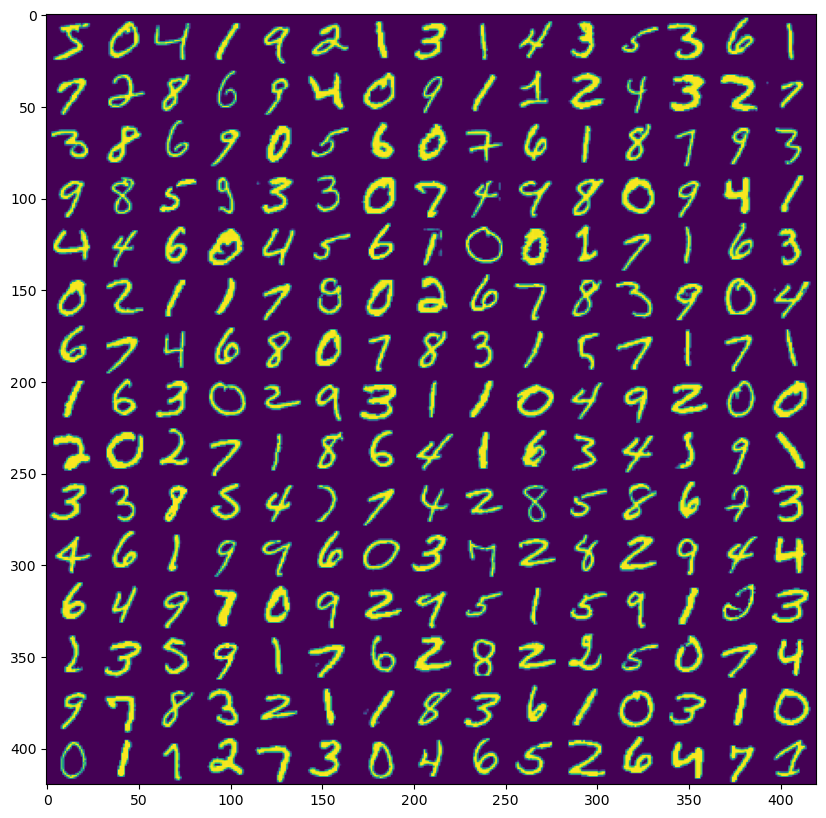

225


In [17]:
plot(x_train)

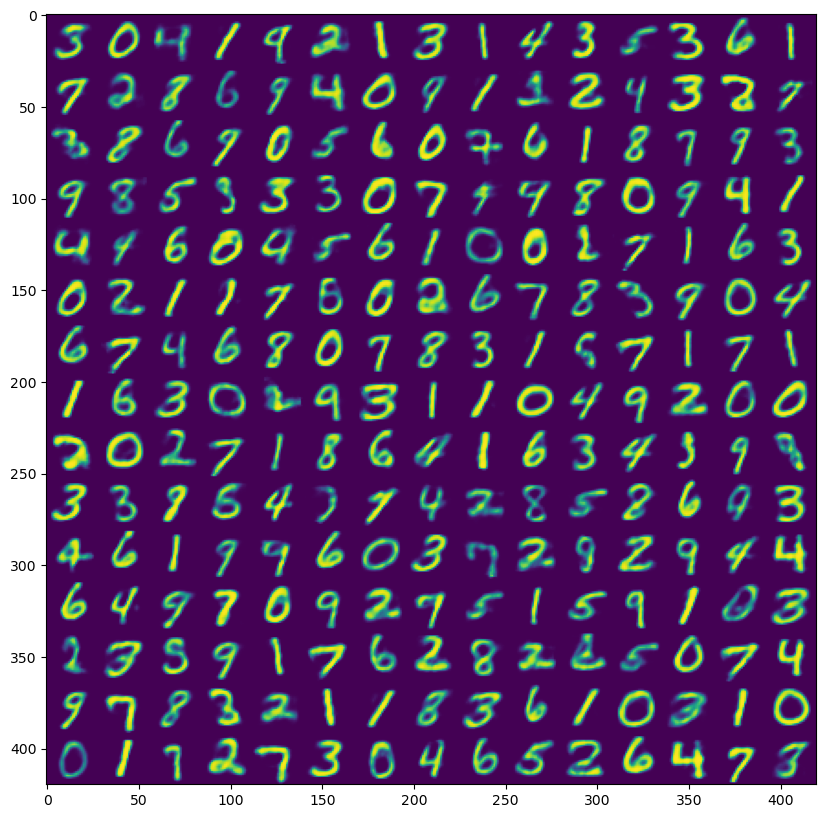

225


In [18]:
plot(x_decoded)